# **Measures of similarity : an analysis of algorithms**

## **Table of Content**
* Introduction
* Preliminaries
* Data preparation
* Modularization of code
* Analysis
* Multiprocessing
* Summary

## **1. Introduction**

---


A similarity measure, in general terms, is a function that determines how similar two data objects are. Most of the time, such a measure is proportional to the reciprocal of the "distance" between objects. In other words, a similarity measure will have a high value (normalized to a scale of 0 to 1) for significantly similar objects and a low value (near to 0) for substantially different objects.
This study investigates two such similarity measures:
*   Jaccard similarity 
*   Cosine similarity 

These are implemented in a variety of ways. In each example, the theoretical time complexity is determined and tested empirically. Furthermore, the feasibility of multiprocessing the same using the Map reduce paradigm is studied, so that large collections of documents may be compared efficiently.

## **2. Preliminaries**
---
<font size="4">**2.1. Time complexity**</font>

Time complexity is a type of computational complexity that specifies how long a computer takes to run an algorithm. It is commonly expressed using the big O notation and is asymptotically proportional to the number of rudimentary operations required.<br />


If time complexity of an algorithm is $O(n^a)$, its run-time can be asymptotically represented as $t = c * n^a$,<br />
where $n$ is the size of the input. Slope of the log-log plot of $t$ and $n$ will give the value of $a$.

## **3. Data Preparation**

---


<font size="4">**3.1. Data Source**</font>

J.K Rowling's famed work, 'Harry Potter and the Order of the Phoenix,' is exported into jupyter notebook for this analysis. With over 16,000 word varieties, this "master document" offers a large pool of data from which random documents may be generated.

<font size="4">**3.2. Data Manipulation**</font>

`nltk.tokenize` package is used to convert the exported text file into a list of words. A function named as `doc_generator`can generate random documents. This function requires the following arguments -

*   The master list of all words
*   Number of words in the generated document

**Fig 1** shows two such random documents.




In [35]:
import random
import pandas as pd 
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool

from collections import Counter, defaultdict
import nltk
from nltk.tokenize import word_tokenize 

doccument = "Harry potter and the order of the phoenix.txt"
master_of_words = [] #a list that will contain the entire doccument, word by word
with open(doccument, encoding = 'mbcs') as file:
    for line in file:
        #tokenize each line into words and add into the master
        master_of_words+=[token.lower() for token in word_tokenize(line.rstrip())]


In [36]:
def doc_generator(master_of_words, number_of_words):
    """"Generates a random bag of words"""
    
    doc = random.choices(master_of_words , k = number_of_words)
    return Counter(doc) #return a bag of words

print(f'Word varieties in the master document : {len(Counter(master_of_words).keys())}')

Word varieties in the master document : 16087


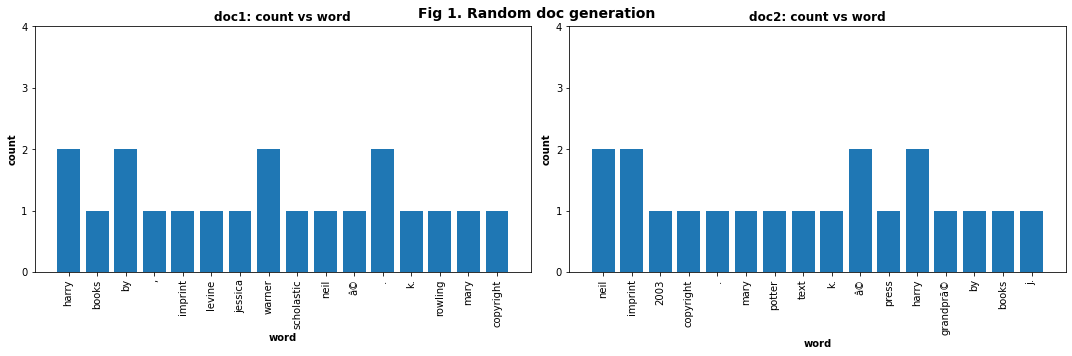

In [38]:
#generating two random documents
random.seed(22)
doc1 = doc_generator(master_of_words[100:150], 20) # a bag of 20 random words
doc2 = doc_generator(master_of_words[100:150], 20)

#plotting bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
axes[0].bar(doc1.keys(),doc1.values())
axes[0].set_title('doc1: count vs word',fontweight="bold")
axes[1].bar(doc2.keys(),doc2.values())
axes[1].set_title('doc2: count vs word', fontweight="bold")

#setting up labels 
for ax in axes:
    ax.set_ylabel('count',fontweight="bold")
    ax.set_xlabel('word', fontweight="bold")
    ax.set_yticks([0,1,2,3,4])
    for label in ax.get_xticklabels():
        label.set(rotation=90)
fig.tight_layout()
fig.suptitle('Fig 1. Random doc generation', size=14, fontweight="bold")
plt.show()

## **3. Modularization of code**

---
All the similarity functions  necessary for this study are coded together in a single class named `similarity`, for the sake of compactness. Objects of this class can be initialised with a pair of bag of words. This class's methods are listed below.
*   `jaccard()` : Returns the jaccard similarity.
*   `cosine()`:  Returns the cosine similarity. Argument can either be *numpy.dot* or a custom function to perform dot product.
*   `sparse_cosine()`:  Returns the cosine similarity evaluated using sparse representation of the given documents
*  `make_dense()`:  Returns the vectorized form of a sparse document 


In [39]:
class similarity: 
    def __init__(self, doc1, doc2): # initializing with two bag of words
        """Initializing the class by generating sparse,
         representations of given docs """
        
        self.sparse_doc1 = doc1 #sparse representation of doc1
        self.sparse_doc2 = doc2 #sparse representation of doc1
        self.all_words = set(list(self.sparse_doc1.keys())+list(self.sparse_doc2.keys())) #set of all words in doc1 and doc2
        
        
    def jaccard(self): 
        """Computes Jaccard similarity using sparse representation"""
        
        total_words = sum(self.sparse_doc1.values())+ sum(self.sparse_doc2.values())
        
        #intersection is as a dictionary, storing the minimum count of a given word amoung the pair
        intersection = {item : min(self.sparse_doc1[item],self.sparse_doc2[item])
                                   for item in self.sparse_doc1.keys() if item in self.sparse_doc2.keys()}
        
       
        return sum(intersection.values())/(total_words - sum(intersection.values())) #returns intersection/union
        

    def cosine(self,func):
        """Computes Cosine similarity using the dense representation.
        Argument : numpy.dot or a custom function."""
        
        vector_doc1 =  self.make_dense(self.sparse_doc1)
        vector_doc2 =  self.make_dense(self.sparse_doc2)
        magnitude_v1 = func(vector_doc1, vector_doc1)**0.5
        magnitude_v2 = func(vector_doc2, vector_doc2)**0.5
        return func(vector_doc1, vector_doc2)/(magnitude_v1*magnitude_v2)
    
    def sparse_cosine(self):
        """For computing Cosine similarity using the sparse representation."""
        
        numerator = [self.sparse_doc1[item]*self.sparse_doc2[item] for item in self.sparse_doc1.keys()
                    if item in self.sparse_doc2.keys()]
        
        #numerator comprises of product of values of the common words
        magnitude_doc1 = sum([value**2 for value in self.sparse_doc1.values()])**0.5
        #magnitude is the root-square value 
        magnitude_doc2 = sum([value**2 for value in self.sparse_doc2.values()])**0.5
        denominator = magnitude_doc1*magnitude_doc2
        return sum(numerator)/denominator
    
    def make_dense(self, sparse_doc):
        """Generates a dense representation from a sparse version."""
        
        #creating a dictionary of all words and 
        dense_dict = {}
        for word in self.all_words: 
            dense_dict[word] = sparse_doc.get(word,0) # generates a dictionary of all words
                                                      # populates the same with the corresponding count in given doc
        return np.array(list(dense_dict.values()))

def dot_prod(vector_1, vector_2):
    """Performs the  dot product of two vectors."""
    
    prod = [vector_1[i]*vector_2[i] for i in range(len(vector_1))]      
    return sum(prod)


## **3.1. Measurement of run-time**

Run-time measurements are taken using two functions - 
*   `timer()`: Returns the mean and standard deviation of run-time measurements of a function's execution. 
*   `smooth_timer()`: Performs bootstrapping to reduce the effect of outliers. Returns median of several means and the average standard deviation.

Average standard deviation of k samples = <font size="4">$\sqrt{S_{1}^2+S_{2}^2+...+S_{k}^2\over k}$</font>

where, $S_{k}$ is the standard deviation of the $k^{th}$ sample.

**Fig 2** shows a comparison of run-time measurements performed using `timer` and `smooth_timer` 


In [41]:
import timeit
def timer(repeats, somefunc,*args,**kwargs):
    """Measures the run-time (median) of some function."""
    times=[]
    while repeats>0:
        starttime=timeit.default_timer()
        ans=somefunc(*args,**kwargs)
        endtime=timeit.default_timer()
        timetaken=endtime-starttime
        times.append(timetaken)
        repeats-=1
    mean=np.mean(times)
    std = np.std(times)
    return mean, std

def smooth_timer (func_array, *args, trials = 5, repeats = 5,**kwargs):
    """This function performs bootstrapping to minimize the outlier-effect"""
    
    #timer takes multiple trials and appends the result in a list
    ys_dict, std_dict = defaultdict(list), defaultdict(list)
    
    for i in range(trials): 
        for func in func_array:
            mean, std = timer(repeats,func, *args, **kwargs)
            ys_dict[i].append(mean) # all trials are stored as lists
            std_dict[i].append(std) # standard deviations are also stored as a list
               
    # averaging of all trials is done here 
    smooth_ys = []
    average_std = []
    for i in range(len(func_array)):
        trial_values = [ys_dict[j][i] for j in range(trials)]
        std_trial_values = [std_dict[j][i] for j in range(trials)]
        smooth_ys.append(np.median(trial_values)) #mean of medians
        average_std = (sum([sigma**2 for sigma in std_trial_values])/trials)**0.5
        
    return smooth_ys, average_std


In [42]:
#generating a list of instances of the similarity class 
from collections import defaultdict
random.seed(20)
xs = [] #list for number of words

#creating a dictionary of lists, each list being a collection of similarity objects
sim_objs = defaultdict(list)
for number_of_words in range(50,2000,20):
    xs.append(number_of_words)
    doc1 = doc_generator(master_of_words[:2 * number_of_words], number_of_words) # a random bag of words
    doc2 = doc_generator(master_of_words[-2 * number_of_words:], number_of_words)
    doc_of_unique_words1 = doc_generator(list(set(master_of_words))[:5000], number_of_words) # a bag of unique words 
    doc_of_unique_words2 = doc_generator(list(set(master_of_words))[5000:], number_of_words) # a different bag of unique words
    
    sim_objs['Identical pairs'].append(similarity(doc1, doc1))
    sim_objs['Distinct pairs'].append(similarity(doc1, doc2))
    sim_objs['Identical pairs, with no repeat words'].append(similarity(doc_of_unique_words1, doc_of_unique_words1))
    sim_objs['Distinct pairs, with no repeat words'].append(similarity(doc_of_unique_words1, doc_of_unique_words2))



## **4.  Analysis**

---
<font size="4">**4.1. Jaccard similarity**</font>

Jaccard similarity between two objects is measured as the ratio of Intersection to the Union.

Jaccard similarity between $A$ and $B$ = <font size="4">$A\bigcap B \over A \bigcup B$ </font>

The required computation is achieved through `jaccard` function of the `similarity` class.The algorithm is implemented as follows:
* Take two documents, $A$ and $B$, represented as bags of words.
* Loop through all the keys in $A$ and check if each key is present in $B$.
* For every common key, take minimum value among $A$ and $B$.
* Adding all the minimum values together gives the Intersection.
* Summing up all the values in both bags and subtracting off the Intersection gives the Union.
* Finally, the Union to Intersection ratio gives the Jaccard similarity.

<font size="3">**4.1.1 Theoretical run-time of Jaccard similarity**</font>

Since the computation of Jaccard similarity involves comparing the keys within two bags of words, the run-time will be proportional to the number of keys.

For a bag of words with $k$ keys and $n$ words, $k \leq n$.

Since it is required to loop through $k$ keys, run-time will be $O(k)$. For a given number of words $n$, worst-case run-time will correspond to documents with no repeat words, where $k = n$. Time complexity, in this case, will be $O(n)$

<font size="3">**4.1.2 Empirical analysis of run-time**</font>

Following characteristics of document-pairs were taken into consideration.
* Similarity
* Number of words
* Uniqueness of words

Four types of document-pairs were subjected to empirical analysis. 
* Identical documents (similarity = 1)
* Distinct documents (similarity = 0)
* Identical documents with no repeat words
* Distinct documents with no repeat words


Results are plotted in **Fig 3**. 

In [46]:
#calculating the run-time of jaccard similarity of identical pairs and storing in a list 
ys = []
stds = []
for pair in sim_objs['Identical pairs']:
    mean, std = timer(50, pair.jaccard)  #measurement using timer()
    ys.append(mean)
    stds.append(std)

In [44]:
#constructing a dictionary of lists, each list being a collection of similarity.jaccard objects
jaccards = defaultdict(list)
jaccards = {doc_type : [pair.jaccard for pair in list_of_pairs] for doc_type , list_of_pairs in sim_objs.items()}
sm_ys, av_stds = smooth_timer(jaccards['Identical pairs'], trials = 5, repeats = 10) #run-time using smooth_timer()

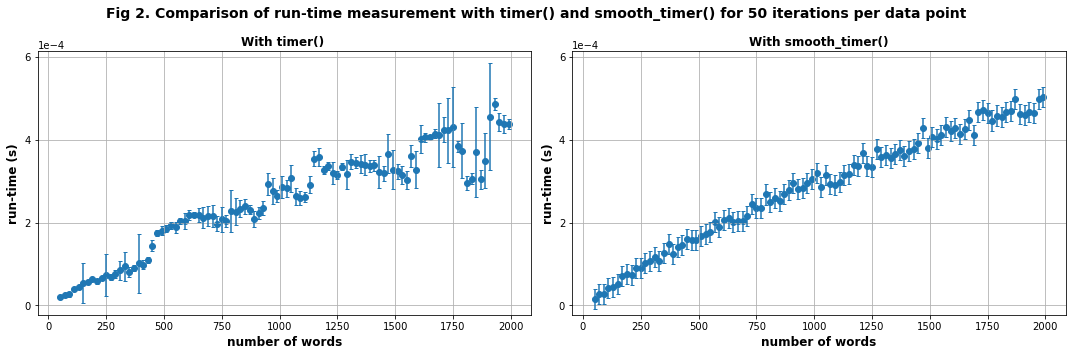

In [47]:
#ploting run-time against numeber of words
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
axes[0].scatter(xs, ys, marker = 'o')
axes[0].errorbar(xs,ys, yerr=stds,fmt='o', markersize=2, capsize=2)
axes[0].set_title('With timer() ', size=12, fontweight="bold")
axes[1].scatter(xs,sm_ys, marker = 'o')
axes[1].set_title('With smooth_timer()',size=12, fontweight="bold")
axes[1].errorbar(xs,sm_ys, yerr = av_stds , fmt = 'o', markersize=2, capsize=2 )

#setting up labels and grid
for ax in axes:
    ax.set_ylabel('run-time (s)', size=12, fontweight="bold")
    ax.set_xlabel('number of words', size=12, fontweight="bold")
    ax.locator_params(axis='y', nbins=5)
    ax.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))
    ax.grid()

#setting up a common y_limit
plt.setp(axes, ylim=axes[0].get_ylim())
fig.suptitle('Fig 2. Comparison of run-time measurement with timer() and smooth_timer() for 50 iterations per data point', size=14, fontweight="bold")
fig.tight_layout()
plt.show()

In [51]:
#constructing a dictionary of lists, each list being a collection of similarity.jaccard objects
ys_jaccard = {doc_type: smooth_timer(jaccards[doc_type], trials = 10, repeats = 10) for doc_type in sim_objs.keys()}

logxs=[np.log10(x) for x in xs]
logys_jaccard = {doc_type : [np.log10(y) for y in ys] for doc_type,ys in ys_jaccard.items()}

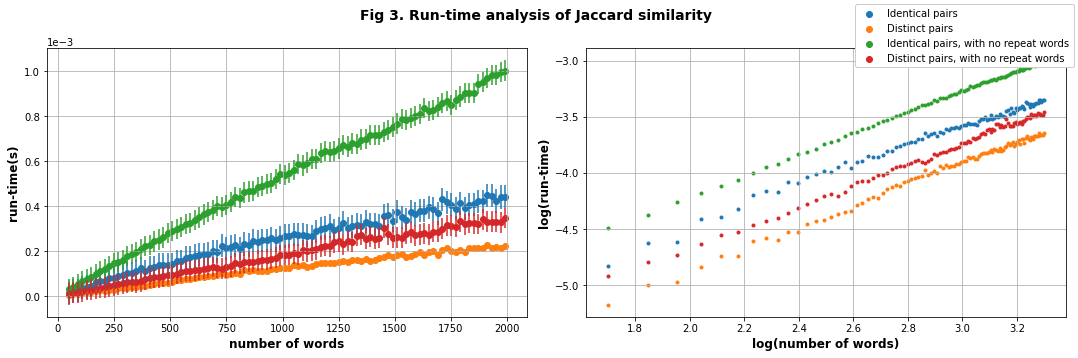

In [52]:
#ploting graphs of run-time and log(run-time) for jaccard similarity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
labels = ['Identical pairs','Distinct pairs','Identical pairs, with no repeat words','Distinct pairs, with no repeat words']
for i, (ys, err) in enumerate(ys_jaccard.values()):
    axes[0].scatter(xs,ys, marker= 'o' ,label = labels[i])
    axes[0].errorbar(xs,ys, yerr= err,  fmt = 'o', markersize=0.2)
    
for logys, err in logys_jaccard.values():
    axes[1].scatter(logxs,logys, marker = '.')
for ax in axes:
    ax.grid()

#assigning legends
lines = []
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
fig.legend(lines ,labels,  loc='upper right',frameon = True, framealpha = 1)

#assigning labels 
axes[0].set_ylabel('run-time(s)', size=12, fontweight="bold")
axes[1].set_ylabel('log(run-time)', size=12, fontweight="bold")
axes[0].set_xlabel('number of words', size=12, fontweight="bold")
axes[1].set_xlabel('log(number of words)', size=12, fontweight="bold")
axes[0].ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))
fig.suptitle('Fig 3. Run-time analysis of Jaccard similarity', size=14, fontweight="bold")

fig.tight_layout()

#linear regression of log run-time happens here
df_jaccards = pd.DataFrame(columns=['Type', 'Slope', 'Error in slope', 'Intercept']) #creating a dataframe for storing results
index = 0
for doc_type, (logys, err) in logys_jaccard.items():
    res = stats.linregress(logxs, logys)
    df_jaccards.loc[index] = [doc_type, round(res.slope,2), round(res.stderr,4), round(res.intercept,2)]
    index += 1

In [53]:
display(df_jaccards)
print('\033[1m'+'Table 1: linear regression of log(run-time) vs log(number of words)')

,Type,Slope,Error in slope,Intercept
0,Identical pairs,0.85,0.0087,-6.15
1,Distinct pairs,0.96,0.0066,-6.78
2,"Identical pairs, with no repeat words",0.93,0.0026,-6.08
3,"Distinct pairs, with no repeat words",0.94,0.0055,-6.56


Table 1: linear regression of log(run-time) vs log(number of words)


For documents with no repeat words, the slope of the log-log plot is very close to 1, as predicted (**Table 1**). Identical document-pairs with no repeat words have the highest run-time since it is the maximum Intersection case and requires more computations.

<font size="4">**4.2 Cosine similarity**</font>

Cosine similarity gauges the geometrical alikeness of two documents. Each word is treated as a dimension in a vector space and each document as a vector. It is defined as the cosine of the angle between two such vectors.

<font size="4">$cos\theta$ = $A.B\over |A| |B|$</font>



`cosine` method of `similarity` class does the required computation.

*  Take two documents $A$ and $B$ represented as vectors.
*  For each dimension, compute the product of vector components.
*  Add all the products to get the dot product , $A.B$
*  Compute the square root of the sum of squares of components to obtain $|A|$ and $|B|$.
*  Divide the dot product by the product of magnitudes.

<font size="3">**4.2.1 Theoretical run-time of Cosine similarity**<font/>

The theoretical run-time of Cosine similarity will depend on the dimensionality of the vector-pair. 

Dimensionality, $d$ $\leq$ $m+n$
 
Where $m$ and $n$ are the number of different words in each vector. Dimensionality is maximum when the vectors are entirely dissimilar - i.e, $ d=m+n $. Hence, the worst-case run-time is $O(n)$.
    
<font size="3">**4.2.2 Empirical analysis of run-time**<font/>

**Fig 4.** shows the comparison of  run-time of Cosine similarity computed using a custom function  `dot_prod ` and `numpy.dot `.

In [54]:
#cosine similarity computation using dot_prod function

#constructing a dictionary of lists, each list being a collection of similarity.cosine objects
cosines = defaultdict(list)
cosines = {doc_type : [pair.cosine for pair in list_of_pairs] for doc_type , list_of_pairs in sim_objs.items()}

#generating smooth-timer outputs and storing in a dictionary
ys_cosines = {doc_type: smooth_timer(cosines[doc_type], dot_prod, trials = 10, repeats = 10) for doc_type in sim_objs.keys()}

logxs=[np.log10(x) for x in xs]
logys_cosines = {doc_type : [np.log10(y) for y in ys] for doc_type,ys in ys_cosines.items()}  #calculating log run-time

In [55]:
#cosine similarity computation using numpy.dot function

#generating smooth-timer outputs and storing in a dictionary
ys_npcosines = {doc_type: smooth_timer(cosines[doc_type],np.dot, trials = 10, repeats = 10) for doc_type in sim_objs.keys()}

logxs=[np.log10(x) for x in xs]
logys_npcosines = {doc_type : [np.log10(y) for y in ys] for doc_type,ys in ys_npcosines.items()} #calculating log run-time

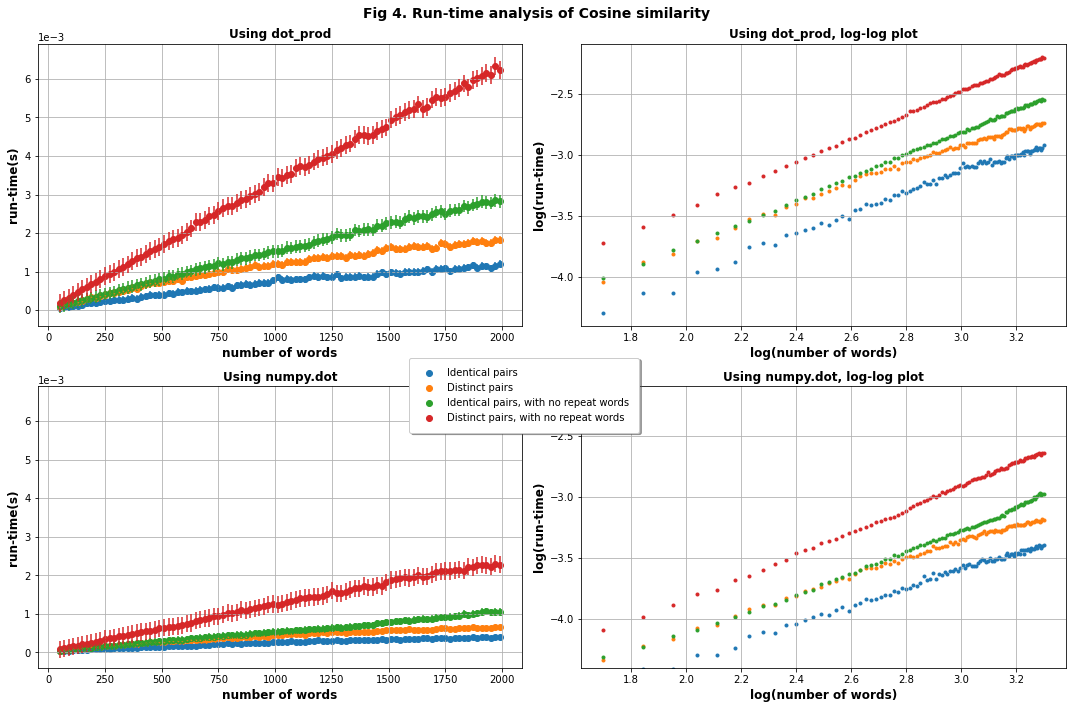

In [56]:
#ploting graphs of run-time and log(run-time) for cosine similarity (using dot_prod and nump.dot)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
labels = ['Identical pairs','Distinct pairs','Identical pairs, with no repeat words','Distinct pairs, with no repeat words']

# plotting all scatted plots 
for i, (ys, err) in enumerate(ys_cosines.values()):
    axes[0,0].scatter(xs, ys, marker= 'o' ,label = labels[i]) 
    axes[0,0].errorbar(xs, ys, yerr= err,  fmt = 'o', markersize=0.5)
for logys, err in logys_cosines.values():
    axes[0,1].scatter(logxs,logys, marker = '.') # plots all run-time scatter plots on the right

for ys, err in ys_npcosines.values():
    axes[1,0].scatter(xs,ys,label = labels[i], marker = 'o') # plots all run-time scatter plots on the left
    axes[1,0].errorbar(xs, ys, yerr= err,  fmt = 'o', markersize=0.5)
for logys, err in logys_npcosines.values():
    axes[1,1].scatter(logxs,logys, marker = '.')

#enabling grid 
for i in range(2):
    for j in range(2):
        axes[i,j].grid()

#adding labels 
lines = []
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
fig.legend(lines ,labels, bbox_to_anchor=(0.6,0.5),frameon = True, framealpha = 1, shadow = True,borderpad=1)

#setting titles
axes[0,0].set_title('Using dot_prod', size=12, fontweight="bold")
axes[1,0].set_title('Using numpy.dot', size=12, fontweight="bold")
axes[0,1].set_title('Using dot_prod, log-log plot', size=12, fontweight="bold")
axes[1,1].set_title('Using numpy.dot, log-log plot', size=12, fontweight="bold")


#setting up labels and limits
for i in range(2):
    axes[i,0].set_xlabel('number of words', size=12, fontweight="bold")
    axes[i,1].set_xlabel('log(number of words)', size=12, fontweight="bold")
    axes[i,0].set_ylabel('run-time(s)', size=12, fontweight="bold")
    axes[i,1].set_ylabel('log(run-time)', size=12, fontweight="bold")
    axes[1,i].set_ylim(axes[0,i].get_ylim())
    
axes[0,0].ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))
axes[1,0].ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))

fig.suptitle('Fig 4. Run-time analysis of Cosine similarity', size=14, fontweight="bold")
fig.tight_layout()

#linear regression of log run-time happens here (cosine using dot_prod)
df_cosines = pd.DataFrame(columns=['Type', 'Slope', 'Error_in_slope', 'Intercept']) #creating a dataframe for storing results
index = 0
for doc_type, (logys,err) in logys_cosines.items():
    res = stats.linregress(logxs, logys)
    df_cosines.loc[index] = [doc_type, round(res.slope,2), round(res.stderr,4), round(res.intercept,2)]
    index += 1

#linear regression of log run-time happens here (cosine using numpy.dot) 
df_npcosines = pd.DataFrame(columns=['Type', 'Slope', 'Error_in_slope', 'Intercept']) #creating a dataframe for storing results
index = 0
for doc_type, (logys, err) in logys_npcosines.items():
    res = stats.linregress(logxs, logys)
    df_npcosines.loc[index] = [doc_type, round(res.slope,2), round(res.stderr,4), round(res.intercept,2)]
    index += 1


In [57]:
display(df_cosines)
print('\033[1m'+'Table 2: Cosine similarity using dot_prod | log(run-time) vs log(number of words)')

display(df_npcosines)
print('\033[1m'+'Table 3: Cosine similarity using numpy.dot | log(run-time) vs log(number of words)')

,Type,Slope,Error_in_slope,Intercept
0,Identical pairs,0.83,0.0083,-5.65
1,Distinct pairs,0.77,0.0075,-5.26
2,"Identical pairs, with no repeat words",0.93,0.0020,-5.59
3,"Distinct pairs, with no repeat words",0.96,0.0019,-5.35


Table 2: Cosine similarity using dot_prod | log(run-time) vs log(number of words)


,Type,Slope,Error_in_slope,Intercept
0,Identical pairs,0.73,0.0055,-5.77
1,Distinct pairs,0.72,0.0054,-5.52
2,"Identical pairs, with no repeat words",0.87,0.0055,-5.88
3,"Distinct pairs, with no repeat words",0.94,0.0030,-5.72


Table 3: Cosine similarity using numpy.dot | log(run-time) vs log(number of words)


In [58]:
#Checking correctness of custon function, dot_prod
doc1,doc2 = doc_generator(master_of_words,50), doc_generator(master_of_words,50)
S1 = similarity(doc1,doc2)
print(f'Cosine similarity using dot_prod = {round(S1.cosine(dot_prod),2)}')
print(f'Cosine similarity using numpy.dot = {round(S1.cosine(np.dot),2)}')

Cosine similarity using dot_prod = 0.49
Cosine similarity using numpy.dot = 0.49


The log-log graphs summarized in **tables 2** and **3** show that distinct document pairs with unique words exhibit near-linear behavior and also consume the highest run-time for a given word count. This is so because being unique-worded and distinct corresponds to the maximum dimensionality condition $(d=2n)$.

As evident in **Fig 4.**, `numpy.dot` performs significantly better than the custom function, `dot_prod`. This is so because `numpy.dot` has a well-refined computation methodology.

<font size="4">**4.3 Cosine similarity using sparse representation**</font>

Cosine similarity can be computed using the sparse representation of documents. This is done using the `sparse_cosine` method of `similarity` class. Methodology is as follows -

* Take two documents, **A**  and **B**, represented as bags of words.
* Loop through each key in documents **A**  and check if the same is present in **B**.
* For every common key, take product of the values in **A** and **B**.
* Add all the products to get the dot product , **A.B**
* Compute the square root of the sum of squares of values to obtain  $|A|$ and $|B|$.
* Divide the dot product by the product of magnitudes.


<font size="3">**4.3.1 Theoretical run-time of sparse_cosine**<font/>
    
Theoretical time complexity will be proportional to the time taken to loop through one of the bags of words. Therefore, as in the case of Jaccard similarity, time complexity will be $O(k)$, where k is the number of keys. Since $k\leq n$, worst case complexity will be $O(n)$. `sparse_cosine` is expected to be less computationally expensive than the dense representation method since, unlike the latter, the former does not require looping through all the dimensions.
    
 


In [18]:
#checking correctness of Cosine similarity in sparse representation
doc1,doc2 = doc_generator(master_of_words,50), doc_generator(master_of_words,50)
S1 = similarity(doc1,doc2)
print(f'Cosine similarity using dense representation = {round(S1.cosine(np.dot),2)}')
print(f'Cosine similarity using sparse representation = {round(S1.sparse_cosine(),2)}')

Cosine similarity using dense representation = 0.43
Cosine similarity using sparse representation = 0.43


Execution of the above  code confirms the correctness of the sparse representation method

In [59]:
#constructing a dictionary of lists, each list being a collection of similarity.sparse_cosine objects
sparse_cosines = defaultdict(list)
sparse_cosines = {doc_type : [pair.sparse_cosine for pair in list_of_pairs] for doc_type , list_of_pairs in sim_objs.items()}

xs = [x for x in range(50,2000,20)]
#calculating run-times and storing in a dictionary
ys_sparse_cosines = {doc_type: smooth_timer(sparse_cosines[doc_type], trials = 10, repeats = 10) for doc_type in sim_objs.keys()}
logxs=[np.log10(x) for x in xs]
logys_sparsecosines = {doc_type : [np.log10(y) for y in ys] for doc_type,ys in ys_sparse_cosines.items()}

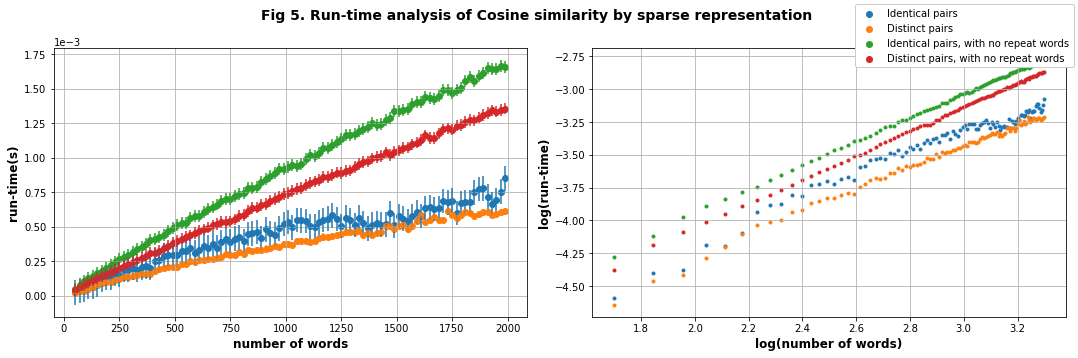

In [60]:
#ploting graphs of run-time and log(run-time) for cosine similarity by sparse representation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
labels = ['Identical pairs','Distinct pairs','Identical pairs, with no repeat words','Distinct pairs, with no repeat words']

for i,(ys, err) in enumerate(ys_sparse_cosines.values()):
    axes[0].scatter(xs,ys,label = labels[i], marker = 'o') #plots all run-time scatter plots on the left
    axes[0].errorbar(xs, ys, yerr= err,  fmt = 'o', markersize=0.5)
    
for logys, err in logys_sparsecosines.values():
    axes[1].scatter(logxs,logys, marker = '.') #plots all log(run-time) scatter plots on the right
for ax in axes:
    ax.grid() #enables grid

lines = []
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels() 
    lines.extend(Line)
fig.legend(lines ,labels,  loc='upper right',frameon = True, framealpha = 1) #enables labels 

axes[0].set_ylabel('run-time(s)', size=12, fontweight="bold")
axes[1].set_ylabel('log(run-time)', size=12, fontweight="bold")
axes[0].set_xlabel('number of words', size=12, fontweight="bold")
axes[1].set_xlabel('log(number of words)', size=12, fontweight="bold")
axes[0].ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))
fig.suptitle('Fig 5. Run-time analysis of Cosine similarity by sparse representation', size=14, fontweight="bold")
fig.tight_layout()

#linear regression of log run-time happens here
df_npcosines = pd.DataFrame(columns=['Type', 'Slope', 'Error_in_slope', 'Intercept']) #create a dataframe for storing results
index = 0
for doc_type, (logys, err) in logys_sparsecosines.items():
    res = stats.linregress(logxs, logys) 
    df_npcosines.loc[index] = [doc_type, round(res.slope,2), round(res.stderr,4), round(res.intercept,2)]
    index += 1

In [21]:
display(df_npcosines)
print('\033[1m'+'Table 4: Cosine similarity using sparse representation | log(run-time) vs log(number of words)')

,Type,Slope,Error_in_slope,Intercept
0,Identical pairs,0.87,0.0117,-5.93
1,Distinct pairs,0.88,0.0077,-6.03
2,"Identical pairs, with no repeat words",0.93,0.0061,-5.74
3,"Distinct pairs, with no repeat words",0.96,0.0042,-5.92


Table 4: Cosine similarity using sparse representation | log(run-time) vs log(number of words)


<font size="3">**4.3.2 Empirical analysis of run-time : sparse_cosine**<font/>
    
Results are plotted in **Fig .5**
*  Identical pairs with no repeat words are observed to consume the highest run-time. 
*  Log-log plot has a slope very close to 1 if words are non-repeating.
*  Worst case time complexity is $O(n)$ , as suggested theoretically 

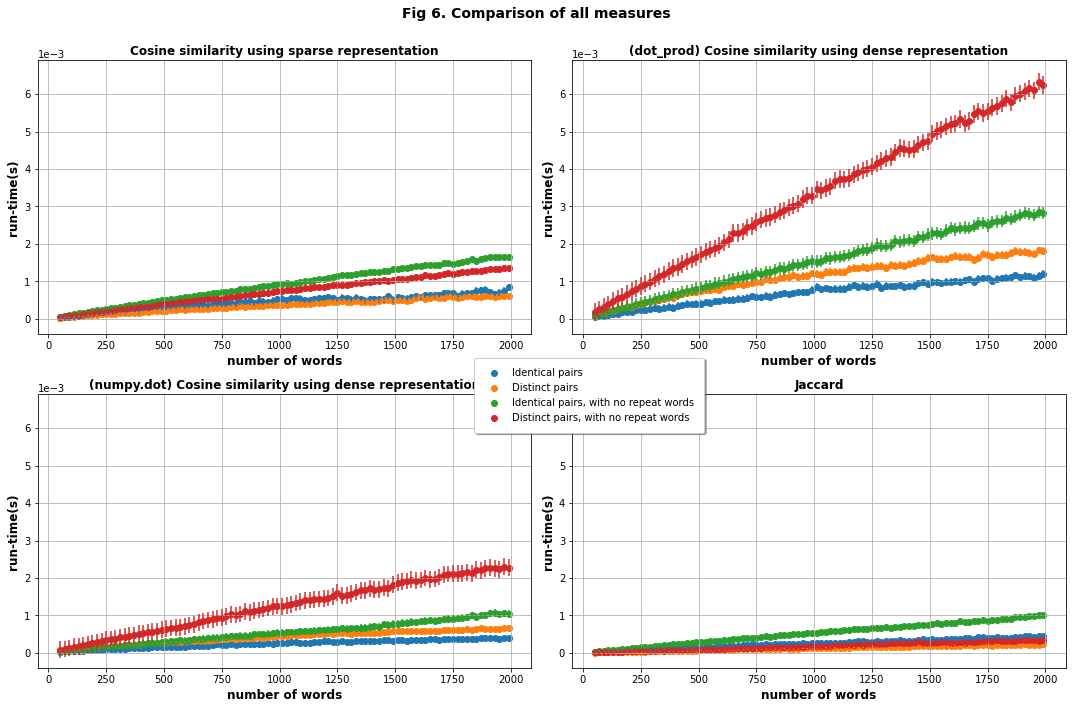

In [61]:
#ploting graphs of run-time and log(run-time) for cosine similarity (using dot_prod and nump.dot)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
labels = ['Identical pairs','Distinct pairs','Identical pairs, with no repeat words','Distinct pairs, with no repeat words']

# plotting all scatted plots 
for i, (ys, err) in enumerate(ys_sparse_cosines.values()):
    axes[0,0].scatter(xs,ys,label = labels[i], marker = 'o') 
    axes[0,0].errorbar(xs, ys, yerr= err,  fmt = 'o', markersize=0.5)
for ys, err in ys_cosines.values():
    axes[0,1].scatter(xs, ys, marker = 'o') # plots all run-time scatter plots on the right
    axes[0,1].errorbar(xs, ys, yerr= err,  fmt = 'o', markersize=0.5)

for ys, err in ys_npcosines.values():
    axes[1,0].scatter(xs,ys,label = labels[i], marker = 'o') # plots all run-time scatter plots on the left
    axes[1,0].errorbar(xs, ys, yerr= err,  fmt = 'o', markersize=0.5)
    
for ys, err in ys_jaccard.values():
    axes[1,1].scatter(xs,ys, marker = 'o')
    axes[1,1].errorbar(xs, ys, yerr= err,  fmt = 'o', markersize=0.5)

#enabling grid 
for i in range(2):
    for j in range(2):
        axes[i,j].grid()
        axes[i,j].set_ylim(axes[0,1].get_ylim())
        axes[i,j].ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))

#adding labels 
lines = []
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
fig.legend(lines ,labels, bbox_to_anchor=(0.66,0.5),frameon = True, framealpha = 1, shadow = True,borderpad=1)

#setting titles
axes[0,0].set_title('Cosine similarity using sparse representation', size=12, fontweight="bold")
axes[1,0].set_title('(numpy.dot) Cosine similarity using dense representation', size=12, fontweight="bold")
axes[0,1].set_title('(dot_prod) Cosine similarity using dense representation', size=12, fontweight="bold")
axes[1,1].set_title('Jaccard', size=12, fontweight="bold")


#setting up labels and limits
for i in range(2):
    for j in range(2):
        axes[i,j].set_xlabel('number of words', size=12, fontweight="bold")
        axes[i,j].set_ylabel('run-time(s)', size=12, fontweight="bold")


fig.suptitle('Fig 6. Comparison of all measures\n', size=14, fontweight="bold")
fig.tight_layout()


**Fig 6.** shows comparison of `sparse_cosine` with `jaccard` and `cosine`. Following are the inferences - 

*  In terms of worst-case run-time, `sparse_cosine` is less efficient than `jaccard`, but better than the dense `cosine`  method
* ` jaccard` and `sparse_cosine` take the least time because they employ dictionaries, which are hashed.
*  Worst case run-time for any similarity measure involving **dense representation** of documents are **distinct pairs with no repeat words**.
* **Identical pairs with no repeat words** are the worst case for any similarity measure involving **sparse representation** of docs.

<font size="4">**4.4 All-pair similarity**<font/>

Similarity of each document-pair within a given list can be computed using the function, `all_pair_similarity`. It returns the extreme similarity values and the locations of the related documents in the list. Arguments required are-
    
*  A list of bag of words 
*  Method to measure similarity, which can be either 'jaccard' or 'cosine'

<font size="3">**4.4.1 Theoretical run-time of all pair similarity**<font/>
    
 For a list of $n$ documents, every document has to be compared to $n-1$ other documents. Total number of comparisons will be 
 $n(n-1)$. Therefore, theoretical time complexity is  $O(n^2)$. Since Jaccard and Cosine both are $O(n)$, time-complexity for an all-pair computation is expected to be independent of the measure used.
    
<font size="3">**4.4.2 Empirical analysis of run-time**<font/>
    
 The variation of run-time with the number of documents was studied. **Fig.7** shows the data for list sizes from 10 to 100. 


In [62]:
def all_pair_similarity(list_of_docs,method = 'jaccard'):
    """This function is reponsible for creation of similarity matrix.
    Returns the most similar and the least similar pair. """
    
    similarity_matrix = [] 
    for doc_1 in list_of_docs:
        if method == 'jaccard':  #computer similarity based on the method input
            row = [similarity(doc_1, doc_2).jaccard() for doc_2 in list_of_docs]
        elif method == 'cosine':
            row = [similarity(doc_1, doc_2).cosine(np.dot) for doc_2 in list_of_docs]
        similarity_matrix.append(row)
        
    #initializing variables to hunt for extreme cases within the similarity matrix
    max_sim,  min_sim, max_i, max_j, min_i, min_j = 0, 2, -1, -1, -1, -1 

    for i in range(len(similarity_matrix)): #hunting for extreme cases of similarity happens here
        for j in range(len(similarity_matrix)):
            if i != j:
                if similarity_matrix[i][j] > max_sim:
                    max_sim = similarity_matrix[i][j]
                    max_i, max_j = i, j
                if similarity_matrix[i][j] < min_sim:
                    min_sim=similarity_matrix[i][j]
                    min_i, min_j = i, j
    return round(min_sim,3), round(max_sim,3), min_i,min_j, max_i,max_j

In [63]:
random.seed(11)
a_list_of_docs = [doc_generator(master_of_words,60) for _ in range(5000)] # a list of 5000 documents, each of with 50 words

#compute run-time for all pair jaccard similarity
xs, ys_all_pair_jaccards, err_all_pair_jaccards= [], [], []
for count in range(10,100,5):
    xs.append(count)
    list_i = random.choices(a_list_of_docs, k = count) #choose k documents at random and call it, list_i
    mean, std = timer(10, all_pair_similarity,list_i) # compute median time to evaluate all pair similarity
    ys_all_pair_jaccards.append(mean) #append results into a list
    err_all_pair_jaccards.append(std)
print('computation completed')

computation completed


In [64]:
#computing run-time for all pair cosine similarity
xs, ys_all_pair_cosines, err_all_pair_cosine = [], [], []
for count in range(10,100,5):  
    xs.append(count)
    list_i = random.choices(a_list_of_docs, k = count)
    mean, std = timer(10, all_pair_similarity, list_i, method = 'cosine') #store median value
    ys_all_pair_cosines.append(mean)
    err_all_pair_cosine.append(std)
print('computation completed')

computation completed


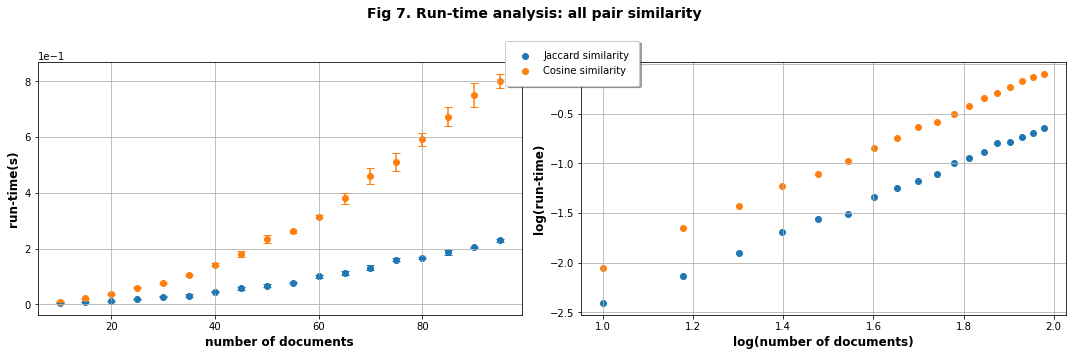

In [65]:
#ploting graphs of run-time and log(run-time)
logxs=[np.log10(x) for x in xs]
labels = ['Jaccard similarity', 'Cosine similarity']
logys_all_pair_jaccards = [np.log10(y) for y in ys_all_pair_jaccards]
logys_all_pair_cosines = [np.log10(y) for y in ys_all_pair_cosines]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
axes[0].scatter(xs, ys_all_pair_jaccards, label = labels[0], marker = 'o')
axes[0].errorbar(xs, ys_all_pair_jaccards, yerr= err_all_pair_jaccards,  fmt = 'o', markersize=0.5, capsize=4)
axes[0].scatter(xs, ys_all_pair_cosines, label = labels[1], marker = 'o')
axes[0].errorbar(xs, ys_all_pair_cosines, yerr= err_all_pair_cosine,  fmt = 'o', markersize=0.5, capsize=4)

axes[1].scatter(logxs , logys_all_pair_jaccards, marker = 'o')
axes[1].scatter(logxs , logys_all_pair_cosines, marker = 'o')

#enabling grid 
for ax in axes:
    ax.grid()
lines = []
#assigning legends
for ax in fig.axes:
    Line, Label = ax.get_legend_handles_labels()
    lines.extend(Line)
fig.legend(lines ,labels,bbox_to_anchor=(0.6,0.9),frameon = True, framealpha = 1, shadow = True,borderpad=1)

#assigning labels 
axes[0].set_ylabel('run-time(s)', size=12, fontweight="bold")
axes[1].set_ylabel('log(run-time)', size=12, fontweight="bold")
axes[0].set_xlabel('number of documents', size=12, fontweight="bold")
axes[1].set_xlabel('log(number of documents)', size=12, fontweight="bold")
axes[0].ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))

fig.suptitle('Fig 7. Run-time analysis: all pair similarity \n', size=14, fontweight="bold")
fig.tight_layout()

#linear regression happens here
df_all_pair = pd.DataFrame(columns=['Type', 'Slope', 'Error_in_slope', 'Intercept']) #dataframe to store coefficients and errors
res_jaccards = stats.linregress(logxs, logys_all_pair_jaccards)
res_cosines =  stats.linregress(logxs, logys_all_pair_cosines)
df_all_pair.loc[0] = ['Jaccard', round(res_jaccards.slope,2), round(res_jaccards.stderr,4), round(res_jaccards.intercept,2)]
df_all_pair.loc[1] = ['Cosine', round(res_cosines.slope,2), round(res_cosines.stderr,4), round(res_cosines.intercept,2)]

In both measures, nonlinear behavior is clear. Theoretical complexity is corroborated by **Table 5**, as the slope of the log-log plot is close to 2. Because computation is more expensive in dense form, Cosine is observed to be more expensive than Jaccard in terms of run-time.

<font size="3">**4.4.3 Run-time for 200K documents**<font/>

Let $t$ denote run-time and $n$ , the list size 

$log(t) = mlog(n) + c$

$m$ and $c$ being the slope and intercept of log-log plot.
   
Hence t can be obtained as 

<font size="4">t = 10<sup>(mlog(n)+c)</sup><font/>

The results are shown in Table 4. For 200k documents, computation in Jacard method takes around $2.91 x 10^5$ seconds and the same using Cosine method, takes around $3.30 x 10^6$ seconds.

In [67]:
df_all_pair['Run-time for 200K docs(s)'] = 10**(df_all_pair['Slope']*np.log10(200000)+df_all_pair['Intercept'])
display(df_all_pair)
print('\033[1m'+'Table 5: All pair similarity | log(run-time) vs log(number of words)')

,Type,Slope,Error_in_slope,Intercept,Run-time for 200K docs(s)
0,Jaccard,1.84,0.0209,-4.29,2.910015e+05
1,Cosine,1.99,0.0143,-4.03,3.304073e+06


Table 5: All pair similarity | log(run-time) vs log(number of words)


## **5. Multiprocessing**
___
Application of the map-reduce paradigm in all-pair similarity computation was studied. Map-reduce is achieved in 5 stages - 

*  `mp_all_pair_similarity` does an initial mapping of the given list of documents by segregating into pairs.
*  `mapper` performs the similarity calculation for each mapped pair and returns the results.
*  `map_reduce_parallel` function stores the results intermediately in the `collector` dictionary.
*  `reducer` function does a re-grouping of the results and returns the output to `map_reduce_parallel`.
*  Finally, `map_reduce_parallel` function returns the extreme similarity values

In [68]:
from multiprocessing import Pool
import mapred # auxiliary python program with the map and reduce functions: mapred.py 

In [70]:
def mapper(inp):
    """similarity calculation is performed here."""

    i , j, doc_i, doc_j, method = inp
    if method == 'jaccard': #performs jaccard calculation if required
        sim = similarity(doc_i,doc_j).jaccard()
    elif method == 'cosine': #performs cosine calculation if required
        sim = similarity(doc_i,doc_j).cosine()
    else:       #raise exception if method is invalid
        raise Exception(f'no method named {method} is available')
    return [((i, j), sim)]

def reducer(item):
    """reducer function."""

    (keys,values) = item
    output = [(keys,values)]
    return (output)

def mp_all_pair_similarity(list_of_docs, method = 'jaccard', mp = 1, rp = 1):
    """performs an intial pair-wise mapping of all docs"""

    items = []
    for i, doc_i in enumerate(list_of_docs): 
        for j, doc_j in enumerate(list_of_docs): 
            items.append((i, j, doc_i, doc_j, method))
    return map_reduce_parallel(items, mapred.mapper, mapred.reducer, mp, rp)


def map_reduce_parallel(inputs, mapper, reducer, mp=1, rp=1):
    """multiprocesssing happens here"""

    collector=defaultdict(list) 
    max_sim,  min_sim, max_i, max_j, min_i, min_j = 0, 2, -1, -1, -1, -1

    mappool = Pool(processes=mp) #map stage
    mapresults=mappool.map(mapper,inputs) 
    mappool.close()
    
   
    for mapresult in mapresults:
        for (key, sim) in mapresult:     
            collector[key].append(sim)  #collector stores all the mapped results
            i, j = key
            if i != j:  #finding the maximum and minimum similarity pairs happens here
                if sim > max_sim: 
                    max_sim = sim
                    max_i, max_j = i, j
                if sim < min_sim:
                    min_sim = sim
                    min_i, min_j = i, j
    #reduce stage
    outputs=[]
    reducepool = Pool(processes=rp)
    
    reduceresults=reducepool.map(reducer,collector.items())
    reducepool.close()
    for reduceresult in reduceresults:
        outputs+=reduceresult
   
    return round(min_sim,3), round(max_sim,3), min_i, min_j, max_i,max_j

Correctness of map-reduce is ensured by comparing the results with and without multiprocessing. This is shown below -

In [74]:
a_list_of_docs = [doc_generator(master_of_words,60) for _ in range(400)] #a list of 400 documents, each having 60 words
result_with_mp = mp_all_pair_similarity(a_list_of_docs) # with map reduce
result_without_mp = all_pair_similarity(a_list_of_docs)  #without map reduce
print(f'Result with multi processing = {result_with_mp} ')
print(f'Result without multi processing = {result_without_mp} ')
print(f'Results are of the format, (minimum similarity, maximum similarity, min_doc_1, min_doc_2, max_doc_1, max_doc_2)')

Result with multi processing = (0.034, 0.304, 176, 340, 174, 345) 
Result without multi processing = (0.034, 0.304, 176, 340, 174, 345) 
Results are of the format, (minimum similarity, maximum similarity, min_doc_1, min_doc_2, max_doc_1, max_doc_2)


Results were found to be comparable.

<font size="3">**5.1 Optimal results**<font/>

The computer used for this study has 8 cores. The run-time for map reduce was studied for different numbers of map and reduce processes.  A random list of 400 documents, each with a word count of 60, was used for the measurement. Mean run-times are shown in **Table 5**, and standard deviations are shown in **Table 6**.

In [75]:
import pandas as pd 

median_dict = defaultdict(list)
std_dict = defaultdict(list)

for j in range(1,5):
    median_dict['Type'].append(f'rp = {j}')
    std_dict['Type'].append(f'rp = {j}')
    

for i in range(1,5):
    median_dict[f'mp = {i}'] = []
    std_dict[f'mp = {i}'] = []
    for j in range(1,5):
        res, std = timer(20,mp_all_pair_similarity, a_list_of_docs,mp=i,rp=j)
        median_dict[f'mp = {i}'].append(res)
        std_dict[f'mp = {i}'].append(std)
        
df_all_pair_mp = pd.DataFrame(median_dict)
all_pair_errors_mp = pd.DataFrame(std_dict)

In [80]:
display(df_all_pair_mp.round(2))
print('\033[1m'+'Table 5: Optimizing parallel processes. Results are in seconds')
display(all_pair_errors_mp.round(2))
print('\033[1m'+'Table 6: standard deviations in run-time measurements')

,Type,mp = 1,mp = 2,mp = 3,mp = 4
0,rp = 1,5.33,3.91,3.74,3.62
1,rp = 2,5.33,3.92,3.71,3.66
2,rp = 3,5.35,4.01,3.78,3.65
3,rp = 4,5.04,4.07,3.80,3.71


Table 5: Optimizing parallel processes. Results are in seconds


,Type,mp = 1,mp = 2,mp = 3,mp = 4
0,rp = 1,0.15,0.16,0.17,0.16
1,rp = 2,0.20,0.14,0.16,0.15
2,rp = 3,0.38,0.17,0.18,0.15
3,rp = 4,0.18,0.20,0.19,0.20


Table 6: standard deviations in run-time measurements


Summarizing **Table 5**, multiprocessing generally reduces the total time required. Four map processes and one reduce process are the most optimal choices, although this might change for a different iteration because of significant errors, as shown in **Table 6**. Further analysis is necessary with a bigger list of documents and a more powerful computer to see bigger differences in run-times

## **5. Summary**
___

* All the implementations of Cosine similarity and Jaccard similarity are $O(n)$ and the same was confirmed emphirically
* Sparse representation is more efficient than the dense alternative. 
* Time complexity of all-pair similarity computation is $O(n^2)$ and is independent of the similarity metric used.
* Map-reduce paradigm was successfully implemented for all-pair similarity computation and was found to be effective. Further analysis is necessary with a bigger list of documents to better establish the effectiveness
